# Classifying CIFAR10 images using Resnet


**Team members:**

Akasha Tigalappanavara

Rohith Mullapudi

Atman Wagle

### Importing the necessary libraries

In [ ]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

## Preparing the Dataset

**Dataset Preprocessing Steps**

**Data Extraction and Loading:**

The CIFAR-10 dataset is extracted from a compressed tar.gz file and each data batch is loaded using a custom unpickling function that reads from binary pickle files.

**Data Reshaping and Normalization:**

The image data is reshaped from one-dimensional arrays into 3-channel images (32x32 pixels) and normalized by converting pixel values to a range of [0,1].

**Dataset Preparation and Augmentation:**

TensorDataset and DataLoader are used for efficient data handling and batching, while transformations such as random cropping and flipping are applied to the training data to enhance generalization.



In [ ]:
import tarfile

# Extract the dataset
dataset_path = './cifar-10-python.tar.gz'
extract_path = './data/cifar-10-batches-py'

with tarfile.open(dataset_path, 'r:gz') as tar:
    tar.extractall(path=extract_path)


In [ ]:
import pickle
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms

# Unpickle function
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Data loading and preprocessing
def load_cifar10_batch(file):
    batch = unpickle(file)
    data = batch[b'data']
    labels = batch[b'labels']
    data = data.reshape((len(data), 3, 32, 32)).astype('float32') / 255
    return torch.tensor(data), torch.tensor(labels)

# Load all training batches
train_data = []
train_labels = []
for i in range(1, 6):
    data, labels = load_cifar10_batch(f'./data/cifar-10-batches-py/cifar-10-batches-py/data_batch_{i}')
    train_data.append(data)
    train_labels.append(labels)

train_data = torch.cat(train_data)
train_labels = torch.cat(train_labels)

# Load test batch
test_data, test_labels = load_cifar10_batch('./data/cifar-10-batches-py/cifar-10-batches-py/test_batch')

# Create TensorDatasets
train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

# Transformations (normalization)
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
transform = transforms.Normalize(*stats)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

In [ ]:
from torch.utils.data import Dataset

class CIFAR10Dataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transforms for training and validation sets
train_transform = transforms.Compose([
    transforms.ToPILImage(),  # Since the transformations expect PIL Image
    transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(*stats),
])

valid_transform = transforms.Compose([
    transforms.ToPILImage(),  # Since the transformations expect PIL Image
    transforms.ToTensor(),
    transforms.Normalize(*stats),
])

# Create datasets
train_dataset = CIFAR10Dataset(train_data, train_labels, transform=train_transform)
valid_dataset = CIFAR10Dataset(test_data, test_labels, transform=valid_transform)

# Create data loaders
train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_dataset, batch_size*2, num_workers=3, pin_memory=True)


### Hyperparameter Sweeping through WandB

We performed the Hyperparameters sweep with the following values:

  sweep_config = {

    'method': 'random'

    'metric': {

        'name': 'val_loss',

        'goal': 'minimize'


    },

    'parameters': {

        'batch_size': {

            'values': [64, 128, 256]

        },

        'max_lr': {

            'values': [0.001, 0.01]

        },

        'epochs': {

            'values': [20]


        },

        'weight_decay': {

            'values': [1e-4, 1e-2]


        },

        'grad_clip': {
            'values': [0.1, 0.5, 1.0]
        }
    }
}



 After the Hyperparameter Sweep in wandb, which lets one visualize the best parameter for the model, we found these values to be the best ones:

batch_size = 64

epochs = 20

max_lr = 0.001

grad_clip = 0.5

weight_decay = 1e-4

opt_func = torch.optim.Adam


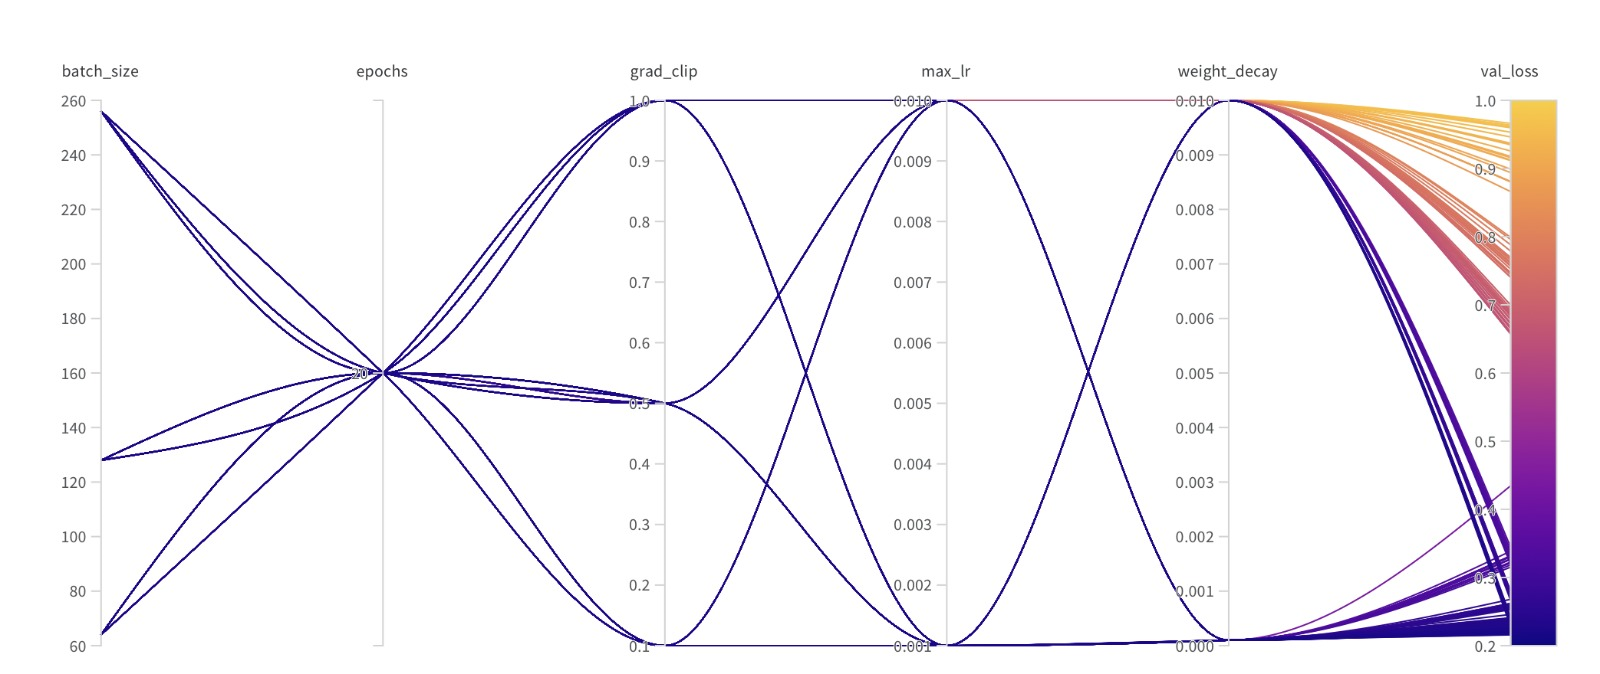


As it was not feasible to train with more number of epochs becuase of the limited time. We trained with 20 epochs and the changed the number of epochs to 100.

In [ ]:
batch_size = 64
epochs = 100
max_lr = 0.001
grad_clip = 0.5
weight_decay = 1e-4
opt_func = torch.optim.Adam

## Using a GPU

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

We can now wrap our training and validation data loaders using `DeviceDataLoader` for automatically transferring batches of data to the GPU (if available).

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

## Model with Residual Blocks and Batch Normalization


In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 428, pool=True)  # Modifying the resnet 9 model here
        self.res2 = nn.Sequential(conv_block(428, 428), conv_block(428, 428))

        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                        nn.Flatten(),
                                        nn.Dropout(0.2),
                                        nn.Linear(428, num_classes))

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [ ]:
model = to_device(ResNet9(3, 10), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_params = count_parameters(model)
print(f"Total number of parameters in the model: {num_params}")


Total number of parameters in the model: 4958958


In [ ]:
from torchsummary import summary

# Print the summary
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,856
       BatchNorm2d-5          [-1, 128, 32, 32]             256
              ReLU-6          [-1, 128, 32, 32]               0
         MaxPool2d-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

## Training the model

Prior to training our model, we plan to implement several key enhancements to our `fit` function:

**Learning rate scheduling**: Rather than maintaining a constant learning rate, we'll introduce a learning rate scheduler that adjusts the rate after each training batch. Various methods exist to modify the learning rate throughout the training process. We will adopt the "One Cycle Learning Rate Policy", which starts with a low learning rate, incrementally raises it batch by batch to a peak rate for about 30% of the epochs, and then progressively lowers it to a minimal rate for the remainder of the epochs.

**Weight decay**: We will also incorporate weight decay, another regularization approach that curtails the growth of the weights by adding an extra term to the loss function.

**Gradient clipping**: To prevent undesirable parameter changes caused by large gradient values, we will implement gradient clipping. This technique limits gradient values within a specified range, which is a straightforward but effective method for stabilizing training.

We have created a `fit_one_cycle` function to integrate these enhancements and have tracked the learning rate for each batch.

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 2.3020341396331787, 'val_acc': 0.1005735769867897}]

We're now ready to train our model.

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl,
                             grad_clip=grad_clip,
                             weight_decay=weight_decay,
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00004, train_loss: 1.5743, val_loss: 1.0867, val_acc: 0.6066
Epoch [1], last_lr: 0.00005, train_loss: 1.1391, val_loss: 0.9010, val_acc: 0.6834
Epoch [2], last_lr: 0.00006, train_loss: 0.9536, val_loss: 0.8086, val_acc: 0.7113
Epoch [3], last_lr: 0.00008, train_loss: 0.8314, val_loss: 0.6828, val_acc: 0.7563
Epoch [4], last_lr: 0.00010, train_loss: 0.7373, val_loss: 0.6586, val_acc: 0.7718
Epoch [5], last_lr: 0.00013, train_loss: 0.6747, val_loss: 0.5703, val_acc: 0.8026
Epoch [6], last_lr: 0.00016, train_loss: 0.6181, val_loss: 0.5687, val_acc: 0.8062
Epoch [7], last_lr: 0.00020, train_loss: 0.5779, val_loss: 0.5791, val_acc: 0.7973
Epoch [8], last_lr: 0.00024, train_loss: 0.5426, val_loss: 0.4779, val_acc: 0.8359
Epoch [9], last_lr: 0.00028, train_loss: 0.5083, val_loss: 0.5218, val_acc: 0.8271
Epoch [10], last_lr: 0.00032, train_loss: 0.4854, val_loss: 0.6918, val_acc: 0.7700
Epoch [11], last_lr: 0.00037, train_loss: 0.4616, val_loss: 0.5816, val_acc: 0.8033
Ep

# **FINAL TEST ACCURACY: 94.02**

#### This will plot the Accuracy vs. No. of epochs curve




In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

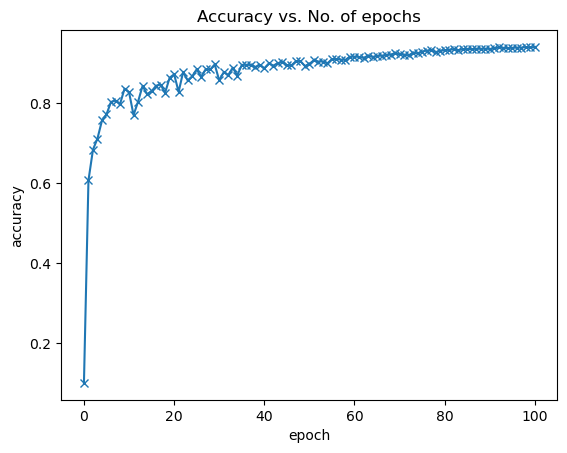

In [ ]:
plot_accuracies(history)

#### This will plot the Loss vs. No. of epochs curve


In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

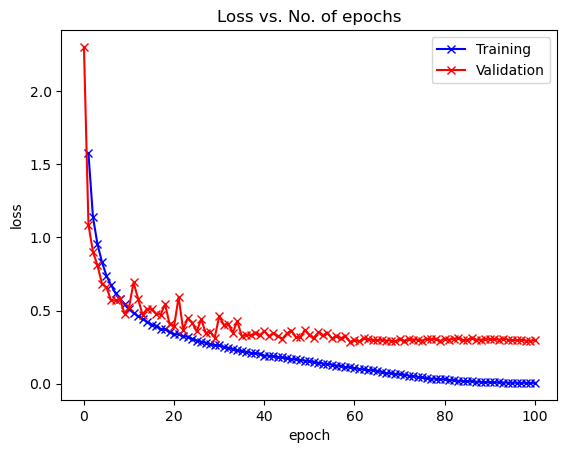

In [ ]:
plot_losses(history)

#### This will plot the Learning Rate vs. Batch no. Curve.


In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

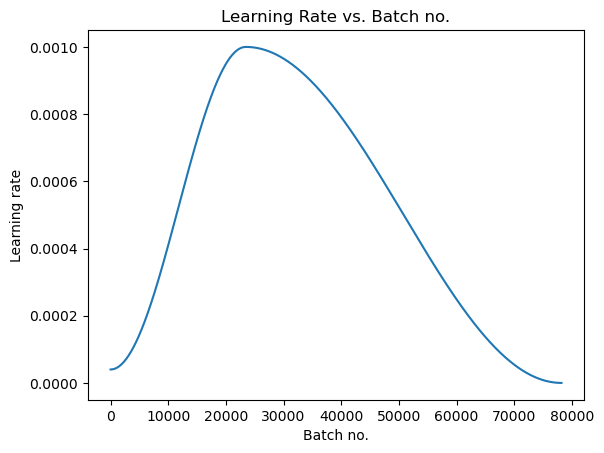

In [ ]:
plot_lrs(history)

As expected, the learning rate starts at a low value, and gradually increases for 30% of the iterations to a maximum value of 0.001, and then gradually decreases to a very small value.

#### Let's test the model on test_data

In [ ]:
def load_cifar10_test_data(file):
    with open(file, 'rb') as fo:
        batch = pickle.load(fo, encoding='bytes')
        data = batch[b'data']
        data = data.reshape((len(data), 3, 32, 32)).astype('float32') / 255
    return torch.tensor(data)

# Load the test data
test_data = load_cifar10_test_data('./cifar_test_nolabels.pkl')

# Assuming IDs are sequential and match the order of the test data
test_ids = np.arange(len(test_data))

# Apply the same transformations as the validation dataset (without labels)
test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(*stats),
])

# Create a test dataset
test_dataset = CIFAR10Dataset(test_data, test_ids, transform=test_transform)

# Create a DataLoader for the test dataset
test_dl = DataLoader(test_dataset, batch_size=64, shuffle=False)


### Predictions

In [ ]:
@torch.no_grad()
def predict(model, data_loader):
    model.eval()
    predictions = []
    for images, _ in data_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.cpu().numpy())
    return predictions

# Get predictions
test_predictions = predict(model, test_dl)


#### Generate the Submission CSV

In [ ]:
import pandas as pd

# Create a DataFrame with IDs and predicted labels
submission_df = pd.DataFrame({
    'ID': test_ids,
    'Label': test_predictions
})

# Save the DataFrame to a CSV file
submission_df.to_csv('submission.csv', index=False)



### Saving the Model

In [ ]:
torch.save(model, 'model.pth')